# Decision Trees

This presentation was created using Jupyter Notebooks

## Library Loading

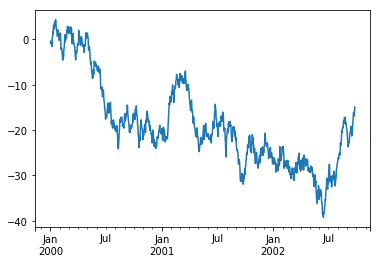

In [2]:
import pandas as pd
from sklearn import datasets
import numpy as np
import graphviz 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.datasets import load_iris

ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
ts.plot()

In [17]:
# Read in the data tables
votes = pd.read_csv("Data/votes.csv")

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='keanedawg', api_key='XEyp2iyNZmSqb0sySR8j')

trace1 = go.Barpolar(
    r=[77.5, 72.5, 70.0, 45.0, 22.5, 42.5, 40.0, 62.5],
    text=['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W'],
    name='11-14 m/s',
    marker=dict(
        color='rgb(106,81,163)'
    )
)
trace2 = go.Barpolar(
    r=[57.49999999999999, 50.0, 45.0, 35.0, 20.0, 22.5, 37.5, 55.00000000000001],
    text=['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W'],
    name='8-11 m/s',
    marker=dict(
        color='rgb(158,154,200)'
    )
)
trace3 = go.Barpolar(
    r=[40.0, 30.0, 30.0, 35.0, 7.5, 7.5, 32.5, 40.0],
    text=['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W'],
    name='5-8 m/s',
    marker=dict(
        color='rgb(203,201,226)'
    )
)
trace4 = go.Barpolar(
    r=[20.0, 7.5, 15.0, 22.5, 2.5, 2.5, 12.5, 22.5],
    text=['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W'],
    name='< 5 m/s',
    marker=dict(
        color='rgb(242,240,247)'
    )
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    title='Wind Speed Distribution in Laurel, NE',
    font=dict(
        size=16
    ),
    legend=dict(
        font=dict(
            size=16
        )
    ),
    radialaxis=dict(
        ticksuffix='%'
    ),
    orientation=270
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='polar-area-chart')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~keanedawg/0 or inside your plot.ly account where it is named 'polar-area-chart'


## Preprocess Vote Data

In [18]:
def pp_vote_delete(votes):
    # drop missing data
    votes = votes.replace('?', np.nan)
    votes = votes.replace('y', 1)
    votes = votes.replace('n', 0)
    votes = votes.dropna()
    
    target = votes['class']
    data1 = votes.drop('class', 1)
    return data1.values, target, votes.columns.values

def pp_vote_ffill_mode(votes):
    # drop missing data
    votes = votes.replace('?', np.nan)
    votes = votes.replace('y', 1)
    votes = votes.replace('n', 0)
    votes = votes.fillna(method='ffill')
    votes = votes.dropna() # ffill is not perfect and may not fill every value
    
    target = votes['class']
    data1 = votes.drop('class', 1)
    return data1.values, target, votes.columns.values

def pp_vote_bfill_mode(votes):
    # drop missing data
    votes = votes.replace('?', np.nan)
    votes = votes.replace('y', 1)
    votes = votes.replace('n', 0)
    votes = votes.fillna(method='bfill')
    votes = votes.dropna() # ffill is not perfect and may not fill every value
    
    target = votes['class']
    data1 = votes.drop('class', 1)
    return data1.values, target, votes.columns.values

vote_clean, vote_target, vote_columns = pp_vote_delete(votes)
print("delete missings: " + str(get_acc(vote_clean, vote_target)))

vote_clean, vote_target, vote_columns = pp_vote_ffill_mode(votes)
print("forward-fill missings: " + str(get_acc(vote_clean, vote_target)))

vote_clean, vote_target, vote_columns = pp_vote_bfill_mode(votes)
print("backwards-fill missings: " + str(get_acc(vote_clean, vote_target)))

delete missings: 0.9714285714285714
forward-fill missings: 0.9389312977099237
backwards-fill missings: 0.9541984732824428


In [33]:
df = pd.DataFrame(columns=['seed', 'tree type', 'acc'])


for x in range(1, 30):
  vote_clean, vote_target, vote_columns = pp_vote_delete(votes)
  delete = get_acc(vote_clean, vote_target)
  df2[-1] = [x, 'delete', delete]
  df = pd.DataFrame(columns=['seed', 'tree type', 'acc'])
  vote_clean, vote_target, vote_columns = pp_vote_ffill_mode(votes)
  ffill = get_acc(vote_clean, vote_target)
  vote_clean, vote_target, vote_columns = pp_vote_bfill_mode(votes)
  bfill = get_acc(vote_clean, vote_target)
  

print(df2)

  seed tree type  acc        -1
0  NaN       NaN  NaN        29
1  NaN       NaN  NaN    delete
2  NaN       NaN  NaN  0.957143


In certain cases, it's clearly better to use forward or backfills, but in other cases, it's clearly better to delete missings. This makes it difficult to make a clear statement of which is a preferable approach.

## Preprocess IRIS Data

For numeric data, try different approaches to binning (e.g., different numbers of bins, and binning by frequency vs. width, etc.). Contrast the results.

For categorical data, try a one-hot strategy and see how it compares to using the category directly.

For missing data, try different approaches and contrast the results.

Try different pruning strategies and note their effectiveness.

In [19]:
def pp_iris_slbin(iris):
    data1 = pd.DataFrame(data = np.c_[iris['data']],
                         columns = iris['feature_names'])
    # Set sepal length bins by this array
    bins = [4, 5, 6, 7, 8]
    grp_names = [4, 5, 6, 7]
    data1['sepal length bin'] = pd.cut(data1['sepal length (cm)'], bins, labels=grp_names)
    data1 = data1.drop('sepal length (cm)', 1)

    return data1.values, iris.target, data1.columns.values

def pp_iris_multibin(iris):
    data1 = pd.DataFrame(data = np.c_[iris['data']],
                         columns = iris['feature_names'])
    # Set sepal length bins by this array
    bins = [4, 5, 6, 7, 8]
    grp_names = [4, 5, 6, 7]
    data1['sepal length bin'] = pd.cut(data1['sepal length (cm)'], bins, labels=grp_names)
    data1 = data1.drop('sepal length (cm)', 1)
   
    bins = [0.0, 0.66, 1.33, 3.0]
    grp_names = [1, 2, 3]
    data1['petal width bin'] = pd.cut(data1['petal width (cm)'], bins, labels=grp_names)
    data1 = data1.drop('petal width (cm)', 1)
    
    return data1.values, iris.target, data1.columns.values

## Test the Data

In [20]:
def get_acc(data, target, seed=17):
    # Splits the data
    data_train, data_test, target_train, target_test = train_test_split(
        data, target, test_size=0.3, random_state=seed)
    classifier = tree.DecisionTreeClassifier(random_state=2)

    # Calls the function to train the data then creates predictions
    model = classifier.fit(data_train, target_train)
    targets_predicted = model.predict(data_test)

    # Print percentage correctly guessed
    error = 1.0 - np.mean( target_test != targets_predicted )
    # print(error)
    return error


# Get iris data from somewhere
iris = load_iris()
iris, target, columns = pp_iris_slbin(iris)
print("1 Bins: " + str(get_acc(iris, target)))

iris = load_iris()
iris, target, columns = pp_iris_multibin(iris)
print("2 Bins: " + str(get_acc(iris, target)))

iris = load_iris()
print("No Changes: " + str(get_acc(iris.data, iris.target)))

#data, target, columns = pp_vote_delete(votes)
#print("No Changes: " + str(get_acc(data, target)))

1 Bins: 0.9777777777777777
2 Bins: 0.9777777777777777
No Changes: 0.9777777777777777


It appears that creating discrete values has actually improved the accuracy of the decision tree. I think the more interesting question is why? 



## Visualize Graph

In [333]:
def visualize_graph(clf, columns):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=columns,  
                         class_names=['setosa', 'versicolor', 'virginica'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
    graph = graphviz.Source(dot_data) 
    return graph

#visualize_graph(clf, columns)

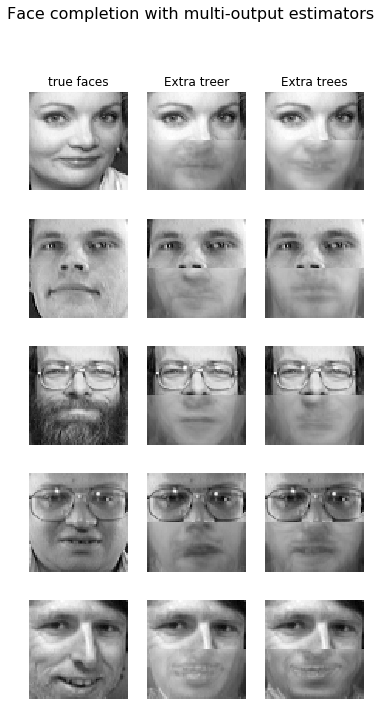

In [35]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state
from sklearn.ensemble import ExtraTreesRegressor


# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=32,
                                       random_state=0),
    "Extra treer": ExtraTreesRegressor(n_estimators=10, max_features=64,
                                       random_state=0)
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()